## Imports 

In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import gzip 
import json 
import polars as pl
import re
import ast
import seaborn as sns

## Load Data 

In [2]:
# AUS user reviews might not be needed 
aus_user_reviews_path = "./data/australian_user_reviews.json.gz"

# AUS user items could be used for user demographic info 
# Or for user-to-user similarity if thats needed in the future
aus_user_items_path = "./data/australian_users_items.json.gz" 

# Game specific metadata, will be useful for predictions 
steam_games_path = "./data/steam_games.json.gz" 

# This in combination with the metadata will need to be used for predictions
# This file doesn't have user id or game metadata 
steam_reviews_path = "./data/steam_reviews.json.gz" # This should be the 1.2 GiB version 

In [3]:
# If files dont exist: print 
for path in [steam_games_path, steam_reviews_path]:
    if not os.path.exists(path):
        print(f"File {path} does not exist")
        print("Please put the files in the ./data/ folder")

In [4]:
def read_file_lazily(file_path): 
    # Create a generator for the file to prevent OOM errors 
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i % 1000000 == 0:
                print(i)
            item = ast.literal_eval(line)
            yield item

def get_lazyframe_from_file_path(file_path):
    # Return lazy frame to prevent OOC and OOM errors
    return pl.LazyFrame(read_file_lazily(file_path))

### Steam Games Metadata

In [53]:
games_df = get_lazyframe_from_file_path(steam_games_path)

0


In [54]:
games_df.head().collect()

publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
str,list[str],str,str,str,str,list[str],f64,str,list[str],str,bool,str,str,str,str
"""Kotoshiro""","[""Action"", ""Casual"", … ""Strategy""]","""Lost Summoner Kitty""","""Lost Summoner Kitty""","""http://store.steampowered.com/…","""2018-01-04""","[""Strategy"", ""Action"", … ""Simulation""]",4.49,"""http://steamcommunity.com/app/…","[""Single-player""]","""4.99""",false,"""761140""","""Kotoshiro""",null,null
"""Making Fun, Inc.""","[""Free to Play"", ""Indie"", … ""Strategy""]","""Ironbound""","""Ironbound""","""http://store.steampowered.com/…","""2018-01-04""","[""Free to Play"", ""Strategy"", … ""Design & Illustration""]",null,"""http://steamcommunity.com/app/…","[""Single-player"", ""Multi-player"", … ""In-App Purchases""]","""Free To Play""",false,"""643980""","""Secret Level SRL""","""Mostly Positive""",null
"""Poolians.com""","[""Casual"", ""Free to Play"", … ""Sports""]","""Real Pool 3D - Poolians""","""Real Pool 3D - Poolians""","""http://store.steampowered.com/…","""2017-07-24""","[""Free to Play"", ""Simulation"", … ""Multiplayer""]",null,"""http://steamcommunity.com/app/…","[""Single-player"", ""Multi-player"", … ""Stats""]","""Free to Play""",false,"""670290""","""Poolians.com""","""Mostly Positive""",null
"""彼岸领域""","[""Action"", ""Adventure"", ""Casual""]","""弹炸人2222""","""弹炸人2222""","""http://store.steampowered.com/…","""2017-12-07""","[""Action"", ""Adventure"", ""Casual""]",0.83,"""http://steamcommunity.com/app/…","[""Single-player""]","""0.99""",false,"""767400""","""彼岸领域""",null,null
null,null,"""Log Challenge""",null,"""http://store.steampowered.com/…",null,"[""Action"", ""Indie"", … ""Sports""]",1.79,"""http://steamcommunity.com/app/…","[""Single-player"", ""Full controller support"", … ""Room-Scale""]","""2.99""",false,"""773570""",null,null,null


In [55]:
# convert column 'id' to int 
cleaned_games_df = games_df.with_columns(pl.col("id").cast(pl.Int32))
cleaned_games_df.head().collect()

publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
str,list[str],str,str,str,str,list[str],f64,str,list[str],str,bool,i32,str,str,str
"""Kotoshiro""","[""Action"", ""Casual"", … ""Strategy""]","""Lost Summoner Kitty""","""Lost Summoner Kitty""","""http://store.steampowered.com/…","""2018-01-04""","[""Strategy"", ""Action"", … ""Simulation""]",4.49,"""http://steamcommunity.com/app/…","[""Single-player""]","""4.99""",false,761140,"""Kotoshiro""",null,null
"""Making Fun, Inc.""","[""Free to Play"", ""Indie"", … ""Strategy""]","""Ironbound""","""Ironbound""","""http://store.steampowered.com/…","""2018-01-04""","[""Free to Play"", ""Strategy"", … ""Design & Illustration""]",null,"""http://steamcommunity.com/app/…","[""Single-player"", ""Multi-player"", … ""In-App Purchases""]","""Free To Play""",false,643980,"""Secret Level SRL""","""Mostly Positive""",null
"""Poolians.com""","[""Casual"", ""Free to Play"", … ""Sports""]","""Real Pool 3D - Poolians""","""Real Pool 3D - Poolians""","""http://store.steampowered.com/…","""2017-07-24""","[""Free to Play"", ""Simulation"", … ""Multiplayer""]",null,"""http://steamcommunity.com/app/…","[""Single-player"", ""Multi-player"", … ""Stats""]","""Free to Play""",false,670290,"""Poolians.com""","""Mostly Positive""",null
"""彼岸领域""","[""Action"", ""Adventure"", ""Casual""]","""弹炸人2222""","""弹炸人2222""","""http://store.steampowered.com/…","""2017-12-07""","[""Action"", ""Adventure"", ""Casual""]",0.83,"""http://steamcommunity.com/app/…","[""Single-player""]","""0.99""",false,767400,"""彼岸领域""",null,null
null,null,"""Log Challenge""",null,"""http://store.steampowered.com/…",null,"[""Action"", ""Indie"", … ""Sports""]",1.79,"""http://steamcommunity.com/app/…","[""Single-player"", ""Full controller support"", … ""Room-Scale""]","""2.99""",false,773570,null,null,null


In [56]:
# Find null cols
print(cleaned_games_df.null_count().collect()[:, :8])
print(cleaned_games_df.null_count().collect()[:, 8:])

shape: (1, 8)
┌───────────┬────────┬──────────┬───────┬─────┬──────────────┬──────┬────────────────┐
│ publisher ┆ genres ┆ app_name ┆ title ┆ url ┆ release_date ┆ tags ┆ discount_price │
│ ---       ┆ ---    ┆ ---      ┆ ---   ┆ --- ┆ ---          ┆ ---  ┆ ---            │
│ u32       ┆ u32    ┆ u32      ┆ u32   ┆ u32 ┆ u32          ┆ u32  ┆ u32            │
╞═══════════╪════════╪══════════╪═══════╪═════╪══════════════╪══════╪════════════════╡
│ 8052      ┆ 3283   ┆ 2        ┆ 2050  ┆ 0   ┆ 2067         ┆ 163  ┆ 31910          │
└───────────┴────────┴──────────┴───────┴─────┴──────────────┴──────┴────────────────┘
shape: (1, 8)
┌─────────────┬───────┬───────┬──────────────┬─────┬───────────┬───────────┬───────────┐
│ reviews_url ┆ specs ┆ price ┆ early_access ┆ id  ┆ developer ┆ sentiment ┆ metascore │
│ ---         ┆ ---   ┆ ---   ┆ ---          ┆ --- ┆ ---       ┆ ---       ┆ ---       │
│ u32         ┆ u32   ┆ u32   ┆ u32          ┆ u32 ┆ u32       ┆ u32       ┆ u32       │
╞══════

### Steam Reviews

In [5]:
reviews_df = get_lazyframe_from_file_path(steam_reviews_path)

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000


In [22]:
reviews_df.group_by("user_id").agg(pl.count("user_id").alias("count")).filter(pl.col("count") >= 5).collect()

user_id,count
str,u32
"""76561198091683702""",5
"""76561198032733014""",5
"""76561198108107409""",10
"""76561198258929285""",18
"""76561198185039370""",6
…,…
"""76561198244128234""",6
"""76561198127301819""",20
"""76561198055166916""",25


In [46]:
reviews_df.head().collect()

username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
str,f64,i64,str,i64,str,str,bool,i64,i64,str,str
"""Chaos Syren""",0.1,41,"""725280""",0,"""2017-12-17""","""This would not be acceptable a…",false,1,null,null,null
"""₮ʜᴇ Wᴀʀᴛᴏɴ""",51.1,769,"""328100""",0,"""2017-12-27""","""looks like a facebook game""",false,1,null,null,null
"""hello?<""",14.6,2,"""328100""",1,"""2017-10-16""","""Better than Minecraft""",false,1,2,"""Product received for free""",null
"""Cyderine916""",5.0,64,"""35140""",0,"""2018-01-04""","""I love and idolized Batman and…",false,1,null,null,null
"""DarklyThinking""",16.6,577,"""35140""",1,"""2018-01-04""","""Still worth playing in 2018. P…",false,1,null,null,"""76561198007483075"""


## Clean Reviews and Save

In [6]:
# product id and user id to int 
# Remame, drop_nulls, etc
cleaned_reviews_df = (
    reviews_df
    .with_columns(
        pl.col("product_id").cast(pl.Int32), 
        pl.col("user_id").cast(pl.Int64),
        pl.col("date").alias("review_date")
    ) # cast to int, and rename date
    .drop(["page_order", "username", "early_access", "compensation", "page", "date"]) # drop useless
    .with_columns(
        pl.col("review_date").str.to_date(strict=False),
    )
    .filter(pl.col("user_id").is_not_null())
    .filter(pl.col("product_id").is_not_null())
    .filter(pl.col("text").is_not_null())
    .filter(pl.col("review_date").is_not_null())
)
print(cleaned_reviews_df.collect().shape)

# Get unique interactions
cleaned_reviews_df = cleaned_reviews_df.unique(subset=["user_id", "product_id"])
cleaned_reviews_df.collect()
print(cleaned_reviews_df.collect().shape)

# Get items with more than 5 reviews 
item_counts = cleaned_reviews_df.group_by("product_id").agg(pl.count("product_id").alias("product_count"))
filtered_items = item_counts.filter(pl.col("product_count") < 5)
cleaned_reviews_df = cleaned_reviews_df.join(filtered_items, on="product_id", how="anti")
print(cleaned_reviews_df.collect().shape)

# Get users with more than 5 reviews
user_counts = cleaned_reviews_df.group_by("user_id").agg(pl.count("user_id").alias("user_count"))
filtered_users = user_counts.filter(pl.col("user_count") < 5)
cleaned_reviews_df = cleaned_reviews_df.join(filtered_users, on="user_id", how="anti")

print(cleaned_reviews_df.collect().shape)

(3176223, 7)
(2832522, 7)
(2823984, 7)
(899837, 7)


In [73]:
cleaned_reviews_df.collect().write_parquet("./data/reviews.parquet", compression="zstd", compression_level=9)

In [12]:
cleaned_reviews_df = pl.scan_parquet("./data/reviews.parquet")

In [74]:
# Sort user items by user and review date for SASRec
sorted_user_items = (
    cleaned_reviews_df
    .with_columns(
        pl.col("user_id").rank(method="dense").alias("mapped_user_id"),
        pl.col("product_id").rank(method="dense").alias("mapped_product_id")
    )
    .sort(["mapped_user_id", "review_date"])
)
sorted_user_items.collect() 

hours,products,product_id,text,found_funny,user_id,review_date,mapped_user_id,mapped_product_id
f64,i64,i32,str,i64,i64,date,u32,u32
4.9,925,33120,"""Alien Shooter: Vengeanceを持ってたら…",null,76561197960267615,2010-12-10,1,650
null,925,30,"""製品とかになる前にANC鯖とか中野鯖などで死ぬほどやった C…",null,76561197960267615,2010-12-10,1,3
7.5,925,35130,"""良作アクションなので懐事情に合わせて買うもよし、セールを待つ…",null,76561197960267615,2010-12-10,1,695
0.0,925,70,"""紛れもないFPS界の金字塔。マスト！ まあ今の人はSourc…",null,76561197960267615,2010-12-10,1,7
null,925,40,"""マップとかまんまQuakeのDMなので懐かしさいっぱい FP…",null,76561197960267615,2010-12-10,1,4
…,…,…,…,…,…,…,…,…
2.0,5,349040,"""Im in love with the shape of y…",null,76561198801034135,2018-01-03,92112,4661
0.3,5,674940,"""Laughing and yelling crazily i…",null,76561198801034135,2018-01-04,92112,10202
0.2,5,238460,"""Real arcade""",null,76561198801034135,2018-01-04,92112,1811


In [75]:
sorted_user_items.collect().write_parquet("./data/sorted_reviews.parquet", compression="zstd", compression_level=9)

In [121]:
users

mapped_user_id,count
u32,u32
2,3
7,4
17,4
24,4
35,3
…,…
113920,4
113944,2
113949,3


In [36]:
print(cleaned_reviews_df.null_count().collect()[:, :6])
print(cleaned_reviews_df.null_count().collect()[:, 6:])
hours_zero_count = cleaned_reviews_df.filter(pl.col("hours") == 0).count()
print(hours_zero_count.collect())

shape: (1, 6)
┌──────────┬───────┬──────────┬────────────┬────────────┬──────┐
│ username ┆ hours ┆ products ┆ product_id ┆ page_order ┆ date │
│ ---      ┆ ---   ┆ ---      ┆ ---        ┆ ---        ┆ ---  │
│ u32      ┆ u32   ┆ u32      ┆ u32        ┆ u32        ┆ u32  │
╞══════════╪═══════╪══════════╪════════════╪════════════╪══════╡
│ 0        ┆ 26537 ┆ 14961    ┆ 0          ┆ 0          ┆ 0    │
└──────────┴───────┴──────────┴────────────┴────────────┴──────┘
shape: (1, 6)
┌──────┬──────────────┬──────┬─────────────┬──────────────┬─────────┐
│ text ┆ early_access ┆ page ┆ found_funny ┆ compensation ┆ user_id │
│ ---  ┆ ---          ┆ ---  ┆ ---         ┆ ---          ┆ ---     │
│ u32  ┆ u32          ┆ u32  ┆ u32         ┆ u32          ┆ u32     │
╞══════╪══════════════╪══════╪═════════════╪══════════════╪═════════╡
│ 0    ┆ 0            ┆ 0    ┆ 6592313     ┆ 7647446      ┆ 4616846 │
└──────┴──────────────┴──────┴─────────────┴──────────────┴─────────┘
shape: (1, 12)
┌──────────┬

## Inspect

In [76]:
reviews_df = pl.scan_parquet("./data/sorted_reviews.parquet").drop(["hours", "products", "found_funny", "hours", "text"])

In [34]:
reviews_df.unique("user_id").collect()

product_id,user_id,review_date,mapped_user_id,mapped_product_id
i32,i64,date,u32,u32
204360,76561198064810575,2015-11-23,49477,1177
215670,76561198089440889,2014-02-07,60934,1382
286340,76561198189254177,2016-03-16,82855,2719
2990,76561198194801761,2015-06-12,83327,85
214420,76561198145088648,2015-10-28,76581,1355
…,…,…,…,…
238750,76561198046602387,2014-02-13,39863,1723
252490,76561198021660235,2015-01-21,25549,1991
500,76561197981548323,2013-12-28,7758,21


In [29]:
reviews_df.unique("product_id").collect()

product_id,user_id,review_date,mapped_user_id,mapped_product_id
i32,i64,date,u32,u32
438480,76561197960420417,2017-02-06,114,6314
504400,76561197971127571,2016-12-28,4864,7241
9200,76561197960575030,2017-10-17,225,248
250640,76561197983253220,2015-09-13,9650,1935
370050,76561197966082557,2015-07-07,1901,4877
…,…,…,…,…
19900,76561197960575030,2017-10-17,225,438
411830,76561197965949373,2016-09-20,1859,5833
116120,76561197970509330,2011-10-22,3763,1102


In [64]:
def plot_hist(df, column, bins=100):
    collected_df = df.collect()
    if "user" in column:
        col_str = "User" 
    else:
        col_str = "Game"
    
    number_reviews_per_col = (
        collected_df
        .group_by(column)
        .agg(pl.count(column).alias("review_count"))
    )
    
    review_counts = number_reviews_per_col["review_count"].to_numpy()

    plt.hist(review_counts, bins=bins)
    plt.title(f"Reviews per {col_str}")
    plt.xlabel("Number of Reviews")
    plt.ylabel(f"Count of {col_str}s")
    plt.yscale("log")
    #plt.xscale("log")
    plt.rcParams['savefig.dpi'] = 1000
    plt.savefig(f"./data/{col_str}_hist.png")

In [77]:
def plot_cdf(df, column, bins=100):
    collected_df = df.collect()
    if "user" in column:
        col_str = "User" 
    else:
        col_str = "Game"
    
    number_reviews_per_col = (
        collected_df
        .group_by(column)
        .agg(pl.count(column).alias("review_count"))
    )
    
    review_counts = number_reviews_per_col["review_count"].to_numpy()

    plt.figure(figsize=(8, 6))
    ecdf = sns.ecdfplot(review_counts)
    ecdf.fill_between(ecdf.get_lines()[0].get_xdata(), ecdf.get_lines()[0].get_ydata(), alpha=0.3)
    plt.title(f"Cumulative Distribution of Reviews Per {col_str}")
    plt.xlabel("Number of Reviews")
    plt.ylabel(f"Cumulative {col_str}s")
    #plt.yscale("log")
    if col_str == "User":
        plt.xlim([1, 100])
    else:
        plt.xscale("log") 
        plt.xlim([0, 1000])

    plt.rcParams['savefig.dpi'] = 1000
    plt.savefig(f"./data/{col_str}_cdf.png")
    plt.show()

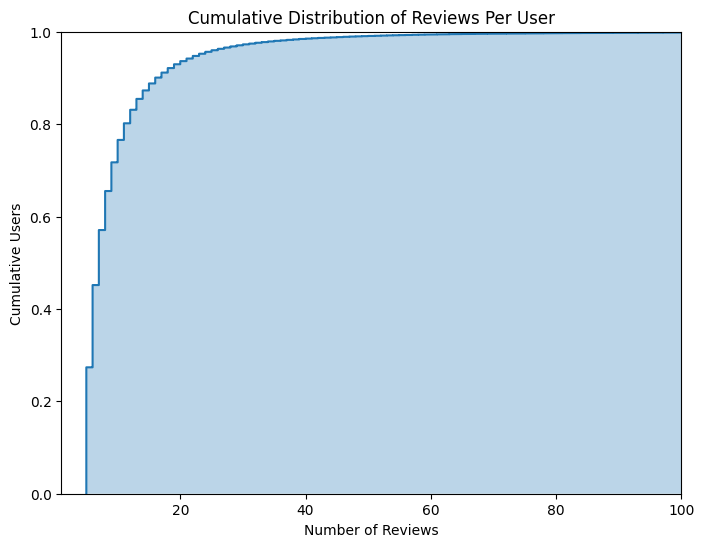

In [78]:
plot_cdf(reviews_df, "mapped_user_id")

/tmp/ipykernel_60538/3576920102.py:27: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 1000])


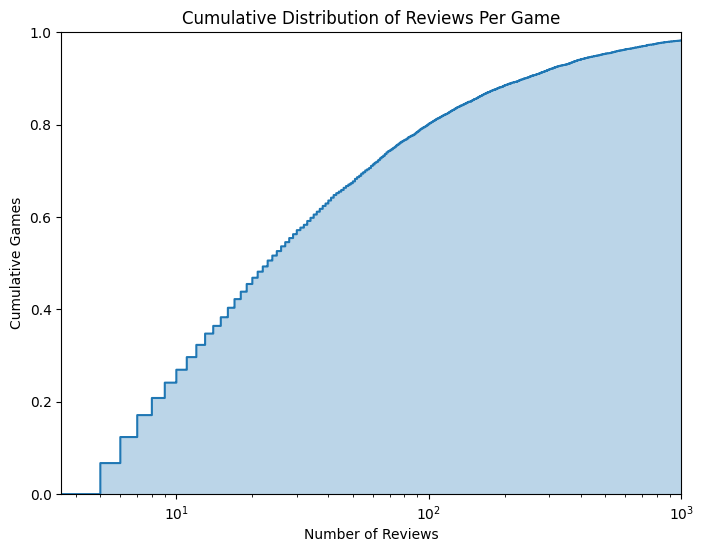

In [62]:
plot_cdf(reviews_df, "mapped_product_id")

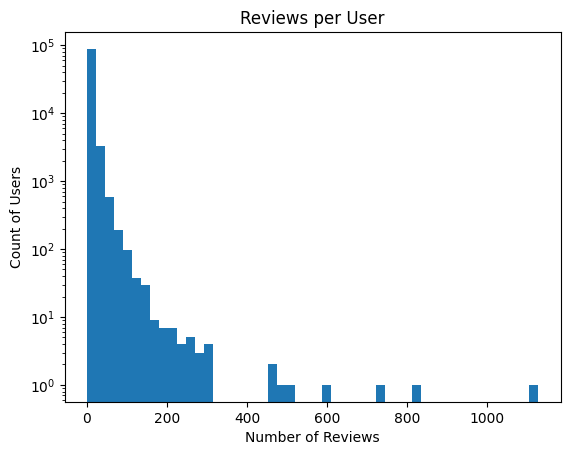

In [65]:
plot_hist(reviews_df, "mapped_user_id", bins=50)

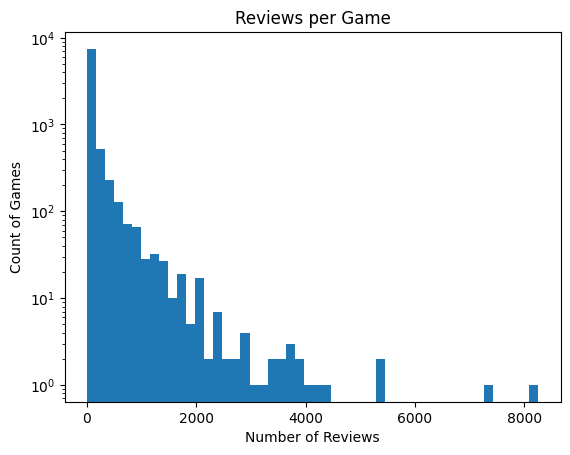

In [32]:
plot_hist(reviews_df, "product_id", bins=50)

## Join Reviews and Games Metadata on Item ID

In [37]:
review_meta_df = cleaned_reviews_df.join(cleaned_games_df, left_on="product_id", right_on="id", how="inner")

In [38]:
print(review_meta_df.head().collect())

shape: (5, 27)
┌────────────┬───────┬──────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ username   ┆ hours ┆ products ┆ product_id ┆ … ┆ early_acce ┆ developer  ┆ sentiment ┆ metascore │
│ ---        ┆ ---   ┆ ---      ┆ ---        ┆   ┆ ss_right   ┆ ---        ┆ ---       ┆ ---       │
│ str        ┆ f64   ┆ i64      ┆ i32        ┆   ┆ ---        ┆ str        ┆ str       ┆ str       │
│            ┆       ┆          ┆            ┆   ┆ bool       ┆            ┆           ┆           │
╞════════════╪═══════╪══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ Chaos      ┆ 0.1   ┆ 41       ┆ 725280     ┆ … ┆ false      ┆ Vyacheslav ┆ Positive  ┆ null      │
│ Syren      ┆       ┆          ┆            ┆   ┆            ┆ Shilikhin  ┆           ┆           │
│ ₮ʜᴇ Wᴀʀᴛᴏɴ ┆ 51.1  ┆ 769      ┆ 328100     ┆ … ┆ false      ┆ Ino-Co     ┆ Mixed     ┆ null      │
│            ┆       ┆          ┆            ┆   ┆            ┆ Plus       ┆

In [41]:
print(review_meta_df.null_count().collect(streaming=True)[:, :6])
print(review_meta_df.null_count().collect(streaming=True)[:, 6:12])
print(review_meta_df.null_count().collect(streaming=True)[:, 12:18])
print(review_meta_df.null_count().collect(streaming=True)[:, 18:24])
print(review_meta_df.null_count().collect(streaming=True)[:, 24:])

shape: (1, 6)
┌──────────┬───────┬──────────┬────────────┬────────────┬──────┐
│ username ┆ hours ┆ products ┆ product_id ┆ page_order ┆ date │
│ ---      ┆ ---   ┆ ---      ┆ ---        ┆ ---        ┆ ---  │
│ u32      ┆ u32   ┆ u32      ┆ u32        ┆ u32        ┆ u32  │
╞══════════╪═══════╪══════════╪════════════╪════════════╪══════╡
│ 0        ┆ 26537 ┆ 14962    ┆ 0          ┆ 0          ┆ 0    │
└──────────┴───────┴──────────┴────────────┴────────────┴──────┘
shape: (1, 6)
┌──────┬──────────────┬──────┬─────────────┬──────────────┬─────────┐
│ text ┆ early_access ┆ page ┆ found_funny ┆ compensation ┆ user_id │
│ ---  ┆ ---          ┆ ---  ┆ ---         ┆ ---          ┆ ---     │
│ u32  ┆ u32          ┆ u32  ┆ u32         ┆ u32          ┆ u32     │
╞══════╪══════════════╪══════╪═════════════╪══════════════╪═════════╡
│ 0    ┆ 0            ┆ 0    ┆ 6597878     ┆ 7653829      ┆ 4620442 │
└──────┴──────────────┴──────┴─────────────┴──────────────┴─────────┘
shape: (1, 6)
┌───────────┬

### Clean Reviews

In [49]:
# drop early access right column, drop samples with null user_id, rename data to review_date 
# drop samples with null sentiment 
cleaned_review_meta_df = (
    review_meta_df
    .drop(["early_access_right", "username", "app_name"])
    .with_columns(pl.col("date").alias("review_date"))
    .filter(pl.col("user_id").is_not_null())
)

In [50]:
# Number of reviews where user id is not null
print(cleaned_review_meta_df.collect().height)

3179096


### Save Cleaned Data

In [52]:
cleaned_review_meta_df.collect().write_parquet("./data/cleaned_review_meta.parquet", compression="zstd", compression_level=9)

KeyboardInterrupt: 

#### Clean Again

In [3]:
df = pl.read_parquet("./data/cleaned_review_meta.parquet")

In [95]:
df.null_count()

hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,publisher,genres,title,url,release_date,tags,discount_price,reviews_url,specs,price,developer,sentiment,metascore,review_date
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
7904,9735,0,0,0,0,0,0,2737588,3128303,0,31274,12898,0,0,3319,18,3173566,0,13864,26609,19518,482,1276230,0


In [104]:
# Convert to datetime
df_datetime = df.with_columns(
    pl.col("review_date").str.to_date(strict=False),
    pl.col("release_date").str.to_date(strict=False)
)

In [105]:
df_datetime.null_count()

hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,publisher,genres,title,url,release_date,tags,discount_price,reviews_url,specs,price,developer,sentiment,metascore,review_date
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
7904,9735,0,0,0,0,0,0,2737588,3128303,0,31274,12898,0,0,15543,18,3173566,0,13864,26609,19518,482,1276230,0


In [106]:
# Remove nulls 
df_filtered = df_datetime.filter(
    pl.col("sentiment").is_not_null() &
    pl.col("tags").is_not_null() &
    pl.col("release_date").is_not_null() &
    pl.col("genres").is_not_null() & 
    pl.col("specs").is_not_null() & 
    pl.col("price").is_not_null() & 
    pl.col("hours").is_not_null() &
    pl.col("publisher").is_not_null() &
    pl.col("developer").is_not_null() & 
    pl.col("products").is_not_null() & 
    pl.col("review_date").is_not_null() &
    pl.col("release_date").is_not_null()
)
    
df_filtered.null_count()

hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,publisher,genres,title,url,release_date,tags,discount_price,reviews_url,specs,price,developer,sentiment,metascore,review_date
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,2653981,3031734,0,0,0,0,0,0,0,3076114,0,0,0,0,0,1222572,0


In [107]:
df_filtered[0]

hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,publisher,genres,title,url,release_date,tags,discount_price,reviews_url,specs,price,developer,sentiment,metascore,review_date
f64,i64,i32,i64,str,str,bool,i64,i64,str,i64,str,list[str],str,str,date,list[str],f64,str,list[str],str,str,str,str,date
16.6,577,35140,1,"""2018-01-04""","""Still worth playing in 2018. P…",false,1,null,null,76561198007483075,"""Warner Bros. Interactive Enter…","[""Action"", ""Adventure""]","""Batman: Arkham Asylum Game of …","""http://store.steampowered.com/…",2010-03-26,"[""Action"", ""Batman"", … ""Horror""]",null,"""http://steamcommunity.com/app/…","[""Single-player"", ""Steam Achievements"", … ""Steam Cloud""]","""19.99""","""Rocksteady Studios,Feral Inter…","""Overwhelmingly Positive""","""91""",2018-01-04


In [109]:
# Drop items and reviews with dates before June 2012, 1 month before first player count reading
from datetime import datetime
cutoff_date = datetime(2012, 6, 1) 
df_filtered_date = df_filtered.filter(pl.col("review_date") >= cutoff_date) 
df_filtered_date = df_filtered_date.filter(pl.col("release_date") >= cutoff_date)
print(len(df_filtered_date))

2425381


In [110]:
# polars: print unique product_id 
review_columns = ["user_id", "product_id", "review_date", "hours", "text", "products", "page", "page_order", "found_funny", "reviews_url"]
product_columns = ["product_id", "sentiment", "developer", "publisher", "release_date", "tags", "genres", "specs", "price"]

reviews = df_filtered_date.select(review_columns)
products = df_filtered_date.unique("product_id").select(product_columns)
print(len(reviews)) 
print(len(products))


2425381
11475


In [111]:
reviews.write_parquet("./data/reviews.parquet", compression="zstd", compression_level=11)

In [112]:
products.write_parquet("./data/products_X.parquet", compression="zstd", compression_level=11)

#### Get Labels 

In [5]:
reviews = pl.read_parquet("./data/reviews.parquet")
reviews

user_id,product_id,review_date,hours,text,products,page,page_order,found_funny,reviews_url
i64,i32,date,f64,str,i64,i64,i64,i64,str
76561197970402776,707610,2017-10-16,1.1,"""no sound. icons don't work. re…",729,1,0,null,"""http://steamcommunity.com/app/…"
76561198060686749,328100,2017-06-23,3.8,"""A nice game, but better not to…",431,1,3,2,"""http://steamcommunity.com/app/…"
76561198159791799,725280,2017-11-13,0.3,"""THE WORST GAME I HAVE EVER PLA…",48,1,4,2,"""http://steamcommunity.com/app/…"
76561198048988003,350280,2018-01-04,1.3,"""BADASS""",93,1,0,null,"""http://steamcommunity.com/app/…"
76561198011965365,328100,2017-03-31,1.3,"""They do a fantastic job of mat…",1689,1,7,null,"""http://steamcommunity.com/app/…"
…,…,…,…,…,…,…,…,…,…
76561197962161824,252490,2013-12-11,2775.2,"""One of the best survival/FPS s…",44,10220,9,null,"""http://steamcommunity.com/app/…"
76561198010660367,252490,2013-12-11,82.2,"""O yes good waiting long time""",91,10221,2,null,"""http://steamcommunity.com/app/…"
76561197983773018,252490,2013-12-11,261.7,"""its so meganice this game Big …",298,10221,3,null,"""http://steamcommunity.com/app/…"


In [8]:
# print users with less than 5 occurences, print items with less than 5 ocurrences
print(reviews["user_id"].unique())

shape: (1_226_556,)
Series: 'user_id' [i64]
[
	76561197960266010
	76561197960266146
	76561197960266225
	76561197960266375
	76561197960266546
	…
	76561198802823358
	76561198802833648
	76561198802851005
	76561198802892043
	76561198802945266
]


In [14]:
reviews.group_by("user_id").agg(pl.count("user_id").alias("count")).filter(pl.col("count") > 5)

user_id,count
i64,u32
76561198032635963,7
76561198157113920,7
76561198002457428,8
76561198131636827,13
76561198094675316,26
…,…
76561197980019537,6
76561198104554518,6
76561198150782214,8
